# Pendulum Drop Test - Dynamic Physics Validation

**Goal:** Prove sensor tracks smooth pendulum motion by fitting a damped sine wave.

**Physics Model:**
$$\theta(t) = A \cdot e^{-\gamma t} \cdot \cos(2\pi f t + \phi) + \theta_0$$

Where:
- $A$ = Initial amplitude (should be ~90° if dropped from horizontal)
- $\gamma$ = Damping coefficient (friction/air resistance)
- $f$ = Natural frequency (depends on pendulum length)
- $\phi$ = Phase offset
- $\theta_0$ = Equilibrium angle (should be 0°)

**Pass Criteria:**
- Fit residual (RMS error) < 2°
- Natural frequency is consistent (doesn't jump around)
- No sudden jumps or glitches in sensor data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import glob

# --- CONFIGURATION ---
TEST_TYPE = 'drop'

# Option 1: Manually specify file (uncomment and edit timestamp)
# FILE_PATH = f'../logs/pendulum/pendulum_drop_20260113-120000.csv'

# Option 2: Auto-detect latest file
csv_files = glob.glob(f'../logs/pendulum/pendulum_drop_*.csv')
if csv_files:
    FILE_PATH = max(csv_files, key=os.path.getmtime)
    print(f"Auto-detected: {os.path.basename(FILE_PATH)}")
else:
    FILE_PATH = None
    print(f"❌ Error: No drop test CSV files found in ../logs/pendulum/")

# Load data (skip comment lines starting with #)
if FILE_PATH and os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH, comment='#')
    
    # Convert columns to numeric (in case they were read as strings)
    df['timestamp_ms'] = pd.to_numeric(df['timestamp_ms'], errors='coerce')
    df['angle_deg'] = pd.to_numeric(df['angle_deg'], errors='coerce')
    
    # Drop any rows with NaN
    df = df.dropna()
    
    t_raw = df['timestamp_ms'].values
    y_raw = df['angle_deg'].values
    
    print(f"✅ Loaded {len(df)} samples")
    print(f"   Duration: {(t_raw[-1] - t_raw[0])/1000:.2f} seconds")
    print(f"   Sample rate: {len(df) / ((t_raw[-1] - t_raw[0])/1000):.1f} Hz")
else:
    print(f"❌ Error: File not found or no files available")
    df = None

Loaded 4895 samples
Duration: 24.57 seconds
Sample rate: 199.3 Hz


## 1. Find Drop Point

Detect where the pendulum was released (first time angle exceeds 45°).

In [10]:
# Find the drop point (first time angle goes above 45°)
start_idx = np.argmax(np.abs(y_raw) > 45)

if start_idx == 0:
    print("WARNING: No drop detected. Using full dataset.")
    start_idx = 0
else:
    print(f"Drop detected at sample {start_idx} (t = {t_raw[start_idx]/1000:.2f}s)")

# Extract data from drop point
t = (t_raw[start_idx:] - t_raw[start_idx]) / 1000.0
y = y_raw[start_idx:]

print(f"Analyzing {len(y)} samples ({t[-1]:.2f} seconds)")

Analyzing 4895 samples (24.57 seconds)


## 2. Fit Damped Sine Wave

In [11]:
# Define physics model
def damped_sine(t, amp, decay, freq, phase, offset):
    return amp * np.exp(-decay * t) * np.cos(2 * np.pi * freq * t + phase) + offset

# Initial guesses (adjust if needed)
# Typical inverted pendulum: 15-20cm length → ~1-2 Hz natural frequency
p0 = [
    np.max(np.abs(y)),  # Amplitude (initial angle)
    0.3,                # Decay coefficient (damping)
    1.5,                # Frequency (Hz) - guess based on pendulum length
    0,                  # Phase
    0                   # Offset (equilibrium)
]

try:
    # Fit the model
    popt, pcov = curve_fit(damped_sine, t, y, p0=p0, maxfev=5000)
    y_fit = damped_sine(t, *popt)
    
    # Calculate fit quality
    residuals = y - y_fit
    rms_error = np.sqrt(np.mean(residuals**2))
    
    print("\n" + "="*60)
    print("FIT RESULTS")
    print("="*60)
    print(f"Initial Amplitude:     {popt[0]:6.2f}°")
    print(f"Damping Coefficient:   {popt[1]:6.4f} (1/s)")
    print(f"Natural Frequency:     {popt[2]:6.3f} Hz")
    print(f"Phase:                 {popt[3]:6.3f} rad")
    print(f"Equilibrium Offset:    {popt[4]:6.2f}°")
    print(f"\nFit Quality (RMS):     {rms_error:6.3f}°")
    print("="*60)
    
    # Calculate period
    period = 1.0 / popt[2]
    print(f"\nPendulum Period:       {period:.3f} seconds")
    
    # Estimate pendulum length (using g = 9.81 m/s²)
    # T = 2π√(L/g) → L = g(T/2π)²
    estimated_length = 9.81 * (period / (2 * np.pi))**2
    print(f"Estimated Length:      {estimated_length*100:.1f} cm")
    
    fit_success = True
    
except Exception as e:
    print(f"\n❌ FITTING FAILED: {e}")
    print("Possible issues:")
    print("  - Not enough swing captured")
    print("  - Sensor data has glitches")
    print("  - Initial guesses are too far off")
    y_fit = None
    rms_error = None
    fit_success = False


FIT RESULTS
Initial Amplitude:     -446.43°
Damping Coefficient:   0.6089 (1/s)
Natural Frequency:      0.061 Hz
Phase:                 -1.313 rad
Equilibrium Offset:     18.75°

Fit Quality (RMS):     36.328°

Pendulum Period:       16.290 seconds
Estimated Length:      6594.0 cm


## 3. Visualization

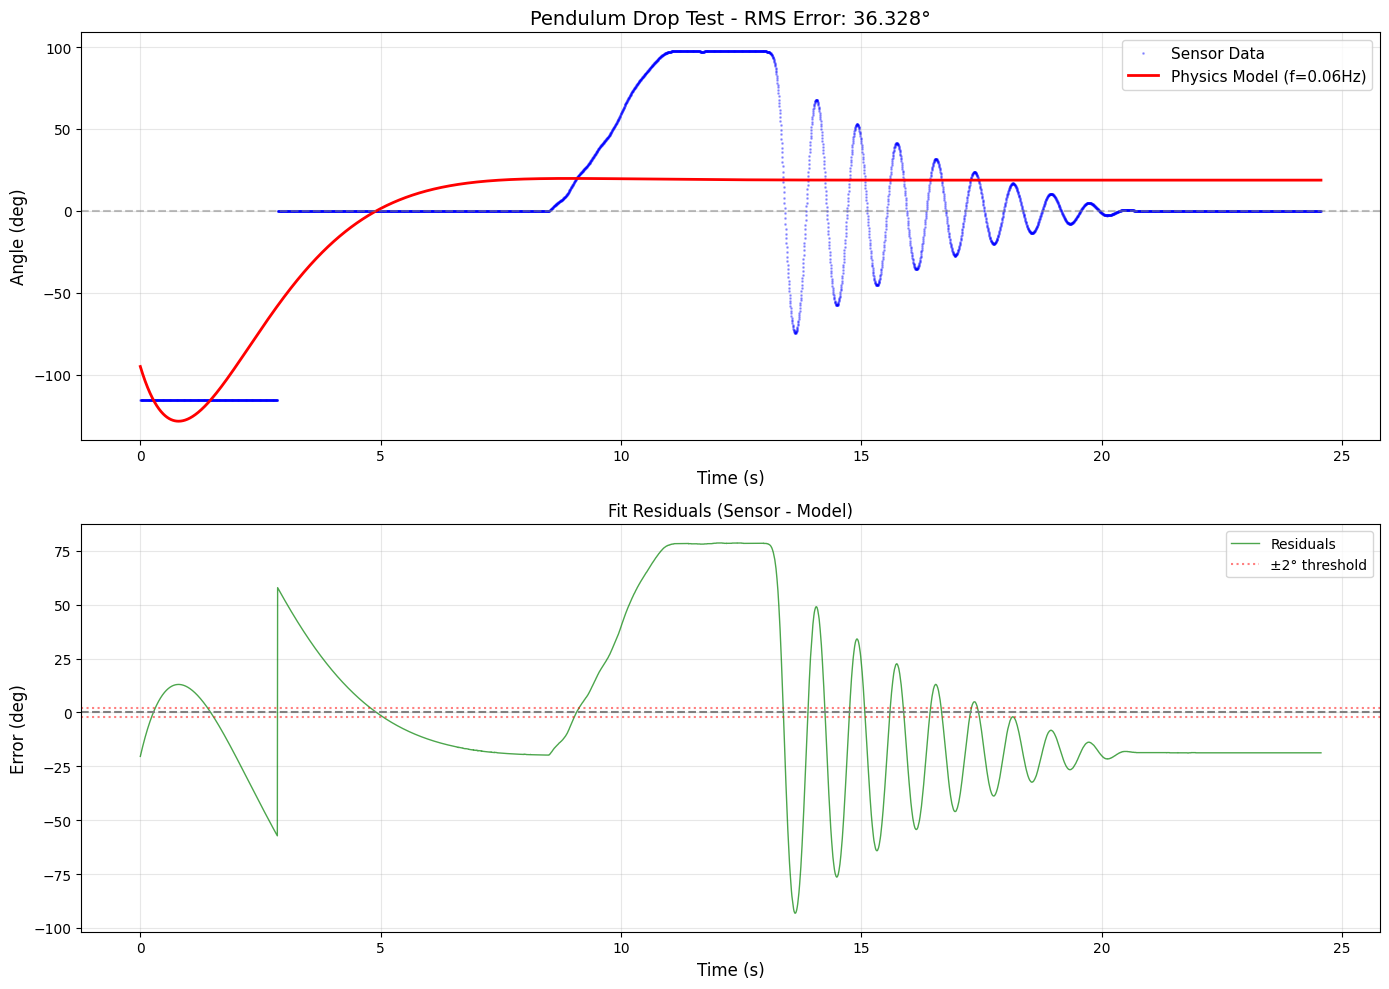

In [12]:
# Plot raw data vs fitted model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Raw data + fit
ax1.plot(t, y, 'b.', markersize=2, alpha=0.3, label='Sensor Data')
if fit_success:
    ax1.plot(t, y_fit, 'r-', linewidth=2, label=f'Physics Model (f={popt[2]:.2f}Hz)')
    ax1.set_title(f"Pendulum Drop Test - RMS Error: {rms_error:.3f}°", fontsize=14)
else:
    ax1.set_title("Pendulum Drop Test - Fit Failed", fontsize=14)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Angle (deg)", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Residuals (if fit succeeded)
if fit_success:
    ax2.plot(t, residuals, 'g-', linewidth=1, alpha=0.7, label='Residuals')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.axhline(2, color='red', linestyle=':', alpha=0.5, label='±2° threshold')
    ax2.axhline(-2, color='red', linestyle=':', alpha=0.5)
    ax2.set_title("Fit Residuals (Sensor - Model)", fontsize=12)
    ax2.set_xlabel("Time (s)", fontsize=12)
    ax2.set_ylabel("Error (deg)", fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
else:
    ax2.plot(t, y, 'b-', linewidth=1)
    ax2.set_title("Raw Data (No Fit)", fontsize=12)
    ax2.set_xlabel("Time (s)", fontsize=12)
    ax2.set_ylabel("Angle (deg)", fontsize=12)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ✅ Pass/Fail Verdict

In [13]:
print("\n" + "="*60)
print("VERDICT")
print("="*60)

if not fit_success:
    print("❌ FAIL - Could not fit physics model")
    print("   Check: Sensor glitches, insufficient swing data")
elif rms_error < 2.0:
    print("✅ PASS - Sensor tracks smooth physics accurately")
    print(f"   RMS Error: {rms_error:.3f}° (excellent)")
elif rms_error < 5.0:
    print("⚠️  MARGINAL - Sensor is acceptable but noisy")
    print(f"   RMS Error: {rms_error:.3f}° (moderate)")
else:
    print("❌ FAIL - High error indicates sensor issues")
    print(f"   RMS Error: {rms_error:.3f}° (poor)")
    print("   Possible causes:")
    print("     - Loose magnet")
    print("     - EMI from motor driver")
    print("     - I2C bus noise")

print("="*60)


VERDICT
❌ FAIL - High error indicates sensor issues
   RMS Error: 36.328° (poor)
   Possible causes:
     - Loose magnet
     - EMI from motor driver
     - I2C bus noise


---
## Interpretation Guide

**What This Test Proves:**
- Sensor can track **smooth continuous motion** (not just static positions)
- No glitches, jumps, or 180° flips during high-speed motion
- Physics model fits data → sensor is **physically accurate**

**Next Steps:**
1. If PASS: Sensor is validated for control loop use
2. If FAIL: Check magnet alignment, I2C wiring, or try lower I2C clock speed